##LSTM Model for Next-day Solar Energy Production Forecasting
This notebook reads data (train and test) created in the 1_data_preparation.ipynb notebook and proceeds to enable training LSTM model variants for next-day solar energy prediction based on weather parameters

In [ ]:
#Import libraries
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import time
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#Can be uncommented if google colab is being used for running the script
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Model Parameter and Directory to be set before running




In [ ]:
#Change model directory based on where model is to be saved
model_dir = '/content/drive/MyDrive/AI_Sustainability/models/'
#Change look_back parameter for increasing or decreasing look-back window
look_back = 7
#Change mode to change the number of LSTM layers in the architecture
mode = '4-layer' #'3-layer' or '1-layer'
EPOCHS = 5
BATCH_SIZE = 128
VAL_SPLIT = 0.2

In [ ]:
# Check for available GPUs and configure TensorFlow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  0


In [ ]:
#Load dataset
train_data = "/content/drive/MyDrive/AI_Sustainability/data/train_data_ensemble_0-agg.csv"
X = pd.read_csv(train_data)
print(X.head())
train_dataset = X[['Date', 'min_dist_node', 'stid', 'tcolc_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0', 'tcdc_eatm_0', 'dswrf_sfc_0',
            'tmax_2m_0', 'tmin_2m_0', 'pwat_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0',
            'uswrf_sfc_0', 'spfh_2m_0', 'ulwrf_sfc_0', 'tmp_2m_0', 'apcp_sfc_0', 'pres_msl_0', 'Daily_Production']]

test_data = "/content/drive/MyDrive/AI_Sustainability/data/test_data_ensemble_0-agg.csv"
X = pd.read_csv(test_data)
test_dataset = X[['Date', 'min_dist_node','stid', 'tcolc_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0', 'tcdc_eatm_0', 'dswrf_sfc_0',
            'tmax_2m_0', 'tmin_2m_0', 'pwat_eatm_0', 'ulwrf_tatm_0', 'dlwrf_sfc_0', 'tmp_sfc_0',
            'uswrf_sfc_0', 'spfh_2m_0', 'ulwrf_sfc_0', 'tmp_2m_0', 'apcp_sfc_0', 'pres_msl_0', 'Daily_Production']]

stations = train_dataset['stid'].unique()
print(f"Number of stations: {len(stations)}")

         Date  stid  Daily_Production  \
0  2000-01-01  ACME          11860500   
1  2000-01-02  ACME          11065500   
2  2000-01-03  ACME          11982900   
3  2000-01-04  ACME          13254000   
4  2000-01-05  ACME          12955200   

                                       new_distances  \
0  {(np.float32(33.0), np.float32(257.0)): 501.30...   
1  {(np.float32(33.0), np.float32(257.0)): 501.30...   
2  {(np.float32(33.0), np.float32(257.0)): 501.30...   
3  {(np.float32(33.0), np.float32(257.0)): 501.30...   
4  {(np.float32(33.0), np.float32(257.0)): 501.30...   

                           min_dist_node  \
0  (np.float32(35.0), np.float32(262.0))   
1  (np.float32(35.0), np.float32(262.0))   
2  (np.float32(35.0), np.float32(262.0))   
3  (np.float32(35.0), np.float32(262.0))   
4  (np.float32(35.0), np.float32(262.0))   

                                            join  tcolc_eatm_0  ulwrf_tatm_0  \
0  20000101(np.float32(35.0), np.float32(262.0))      0.001185     257.

In [ ]:
print(train_dataset.shape)
print(test_dataset.shape)

(179046, 22)
(35770, 22)


##Data Preprocessing

This performs interpolation, NaN filling, Station ID Encoding

In [ ]:
def preprocess_data(df):
    """
    Data preprocessing that adds columns ['day', 'month', 'year'], extract latitude and longitude from 'min_dist_node' column and interpolates values.
    Station ID is also encoded using one-hot encoding.
    """
    # Convert date to datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # Sort by station and date
    df = df.sort_values(["stid", "Date"]).reset_index(drop=True)

    # Extract weather features
    weather_features = [col for col in df.columns if col.endswith("_0")]

    df["dayofyear"] = df["Date"].dt.dayofyear
    df["month"] = df["Date"].dt.month
    df["weekday"] = df["Date"].dt.weekday

    df["min_dist_node"] = df["min_dist_node"].astype(str)

    def extract_float_tuple(s):
        try:
            return tuple(float(part.replace("np.float32(", "").replace(")", "")) for part in s.strip("()").split(","))
        except:
            return (None, None)

    df[['lat', 'lon']] = df['min_dist_node'].apply(lambda x: pd.Series(extract_float_tuple(str(x))))

    df["lat"] = df["lat"].fillna(method="ffill")
    df["lon"] = df["lon"].fillna(method="ffill")

    le = LabelEncoder()
    df["stid_encoded"] = le.fit_transform(df["stid"])

    return df, le, weather_features

In [ ]:
# Preprocess training and test data
train_df, station_encoder, weather_features = preprocess_data(train_dataset)
test_df, _, _ = preprocess_data(test_dataset)

<ipython-input-7-d200071b887c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])
<ipython-input-7-d200071b887c>:29: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["lat"] = df["lat"].fillna(method="ffill")
<ipython-input-7-d200071b887c>:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["lon"] = df["lon"].fillna(method="ffill")
<ipython-input-7-d200071b887c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

##Temporal Sequence Creation
Sliding window is used to create sequence if "look_back" length

In [ ]:
def create_sequences(data, stations, features, target_col, lookback=7):
    """
    Function to created shifted window sequences for all stations for a given look back window
    """
    X_sequences = []
    y_values = []
    station_ids = []
    dates = []

    # Additional features to include (non-weather)
    additional_features = ['dayofyear', 'month', 'weekday', 'lat', 'lon', 'stid_encoded']
    all_features = features + additional_features

    for station in stations:
        # Get data for this station
        station_data = data[data['stid'] == station].copy()
        if len(station_data) <= lookback:
            continue

        # Create sequences for this station
        station_features = station_data[all_features].values
        station_target = station_data[target_col].values
        station_dates = station_data['Date'].values

        for i in range(len(station_data) - lookback):
            X_sequences.append(station_features[i:i+lookback])
            y_values.append(station_target[i+lookback])
            station_ids.append(station)
            dates.append(station_dates[i+lookback])

    return np.array(X_sequences), np.array(y_values), np.array(station_ids), np.array(dates)


In [ ]:
# Extract features and targets
features_cols = weather_features
target_col = 'Daily_Production'
station_list = train_df['stid'].unique()

# Create sequences for training data
X_train_seq, y_train, train_stations, train_dates = create_sequences(
    train_df, station_list, features_cols, target_col, lookback=look_back
)

# Create sequences for test data
X_test_seq, y_test, test_stations, test_dates = create_sequences(
    test_df, station_list, features_cols, target_col, lookback=look_back
)

print(f"Training sequences: {X_train_seq.shape}")
print(f"Training targets: {y_train.shape}")
print(f"Test sequences: {X_test_seq.shape}")
print(f"Test targets: {y_test.shape}")

Training sequences: (178360, 7, 30)
Training targets: (178360,)
Test sequences: (35084, 7, 30)
Test targets: (35084,)


##Feature Scaling
Since each weather parameter is different in range and units, column wise scaling is performed

In [ ]:
# Feature Scaling
scaler_X = StandardScaler()
n_samples_train, n_timesteps, n_features = X_train_seq.shape
X_train_reshaped = X_train_seq.reshape(n_samples_train * n_timesteps, n_features)
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)

n_samples_test, _, _ = X_test_seq.shape
X_test_reshaped = X_test_seq.reshape(n_samples_test * n_timesteps, n_features)
X_test_scaled = scaler_X.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

##Model Definition
LSTM Model is defined with various modes tha can be selected by the used and was used for experimentation

In [ ]:
def lstm_model(input_shape, hidden_layers, mode='4-layer'):
  """
  Function defining LSTM Model
  """
  if mode == '4-layer':
    model = Sequential()
    model.add(LSTM(units=hidden_layers, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
  if model == '3-layer':
    model = Sequential()
    model.add(LSTM(units=hidden_layers, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
  if model == '1-layer':
    model = Sequential()
    model.add(LSTM(units=hidden_layers, input_shape=input_shape, return_sequences=True))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

  return model

In [ ]:
#Define model and visualise summary
input_shape = (look_back, X_train_scaled.shape[2])
lstm_model = lstm_model(input_shape, 128, mode='4-layer')
lstm_model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,265 (559.63 KB)

 Trainable params: 143,265 (559.63 KB)

 Non-trainable params: 0 (0.00 B)

##Model Training

In [ ]:
#Start training and log training time
train_start = time.time()
history = lstm_model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    callbacks=[early_stopping],
    verbose=1
)
train_end = time.time()
print(f"Training time: {train_end - train_start:.2f} seconds")
lstm_model.save(model_dir + f'lstm_model_lag_{look_back}_{mode}.h5')

Epoch 1/5
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 63s 51ms/step - loss: 0.0346 - val_loss: 0.0220
Epoch 2/5
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 78s 48ms/step - loss: 0.0193 - val_loss: 0.0132
Epoch 3/5
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 83s 49ms/step - loss: 0.0119 - val_loss: 0.0094
Epoch 4/5
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 5/5
1115/1115 ━━━━━━━━━━━━━━━━━━━━ 86s 52ms/step - loss: 0.0069 - val_loss: 0.0067


Training time: 392.45 seconds


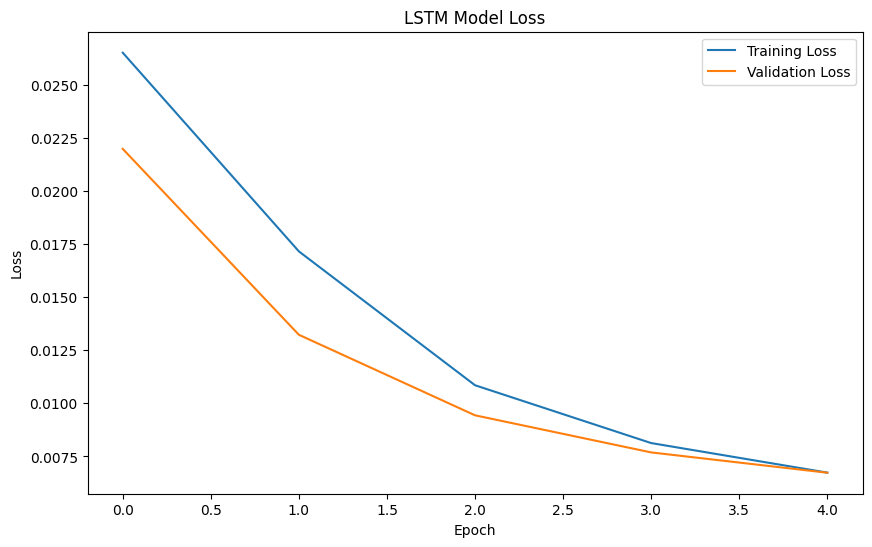

In [ ]:
#Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Model Inference

In [ ]:
#Inference on test dataset and log inference time
infer_start = time.time()
y_pred_scaled = lstm_model.predict(X_test_scaled)
infer_end = time.time()
print(f"Inference time: {infer_end - infer_start:.2f} seconds")

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
Inference time: 10.37 seconds


In [ ]:
#Rescale the predictions to match the target data
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

In [ ]:
#Calculate Average MAE for all dates and across all stations
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

MAE: 4364303.5000


In [ ]:
test_dates = pd.to_datetime(test_df['Date'])
print(test_dates)

0       2005-01-01
1       2005-01-02
2       2005-01-03
3       2005-01-04
4       2005-01-05
           ...    
35765   2005-12-27
35766   2005-12-28
35767   2005-12-29
35768   2005-12-30
35769   2005-12-31
Name: Date, Length: 35770, dtype: datetime64[ns]


##Performance Evaluation and Error Analysis

In [ ]:
df_test = pd.DataFrame(X_test_seq.reshape(X_test_seq.shape[0], -1))
df_test = df_test[[col for col in range(X_test_seq.shape[2]) if col < len(df_test.columns)]]
all_columns = weather_features + ['dayofyear', 'month', 'weekday', 'lat', 'lon', 'stid_encoded']
df_test = df_test[[col for col in range(len(all_columns)) if col < len(df_test.columns)]]

df_test.columns = all_columns
df_test['true'] = y_test
df_test['pred'] = y_pred.flatten()
df_test['error'] = np.abs(df_test['true'] - df_test['pred'])
df_test['date'] = test_dates
df_test['stid'] = test_stations

def report_station_mae(df, top_n=None):
    """
    Calculate and report MAE for each station in the dataset.
    """
    # Calculate MAE per station
    station_mae = df.groupby('stid').apply(
        lambda x: mean_absolute_error(x['true'], x['pred'])
    ).reset_index()
    station_mae.columns = ['Station ID', 'MAE']

    # Calculate additional statistics
    station_stats = df.groupby('stid').agg({
        'true': ['mean', 'std', 'count'],
        'error': ['mean', 'std', 'max']
    }).reset_index()

    # Flatten the multi-index columns
    station_stats.columns = ['Station ID', 'Avg Production', 'Std Production',
                            'Sample Count', 'Avg Error', 'Std Error', 'Max Error']

    # Merge the stats
    station_report = station_mae.merge(station_stats, on='Station ID')

    # Add normalized MAE (MAE / Avg Production)
    station_report['Normalized MAE'] = station_report['MAE'] / station_report['Avg Production']

    # Sort by MAE in descending order
    station_report = station_report.sort_values('MAE', ascending=False)

    if top_n is not None:
        station_report = station_report.head(top_n)

    return station_report

# Generate and print the station MAE report
station_report = report_station_mae(df_test)
print("\nMAE Report by Station (Top 10 worst performing):")
print(station_report.head(10).to_string(index=False))
print(f"\nTotal Stations: {len(station_report)}")
print(f"Average Station MAE: {station_report['MAE'].mean():.4f}")
print(f"Median Station MAE: {station_report['MAE'].median():.4f}")

station_errors = df_test.groupby('stid_encoded')['error'].mean().reset_index()


MAE Report by Station (Top 10 worst performing):
Station ID       MAE  Avg Production  Std Production  Sample Count    Avg Error    Std Error    Max Error  Normalized MAE
      SPEN 5345379.0    1.547441e+07    7.343971e+06           358 5.345379e+06 4.719069e+06 19309246.000        0.345433
      SLAP 5148203.5    1.544402e+07    7.700663e+06           358 5.148203e+06 4.978515e+06 23243728.000        0.333346
      MTHE 5069721.0    1.552799e+07    6.837324e+06           358 5.069721e+06 4.234708e+06 22465547.250        0.326489
      WIST 4921962.0    1.636565e+07    7.384673e+06           358 4.921962e+06 4.173916e+06 22329500.250        0.300749
      PUTN 4825254.5    1.649728e+07    7.110944e+06           358 4.825254e+06 4.599478e+06 20129684.000        0.292488
      STIG 4761833.0    1.661425e+07    7.309265e+06           358 4.761833e+06 4.021887e+06 22267411.375        0.286611
      CLAY 4744933.0    1.670705e+07    7.257488e+06           358 4.744933e+06 4.155586e+06 229

<ipython-input-20-d855222676e9>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  station_mae = df.groupby('stid').apply(


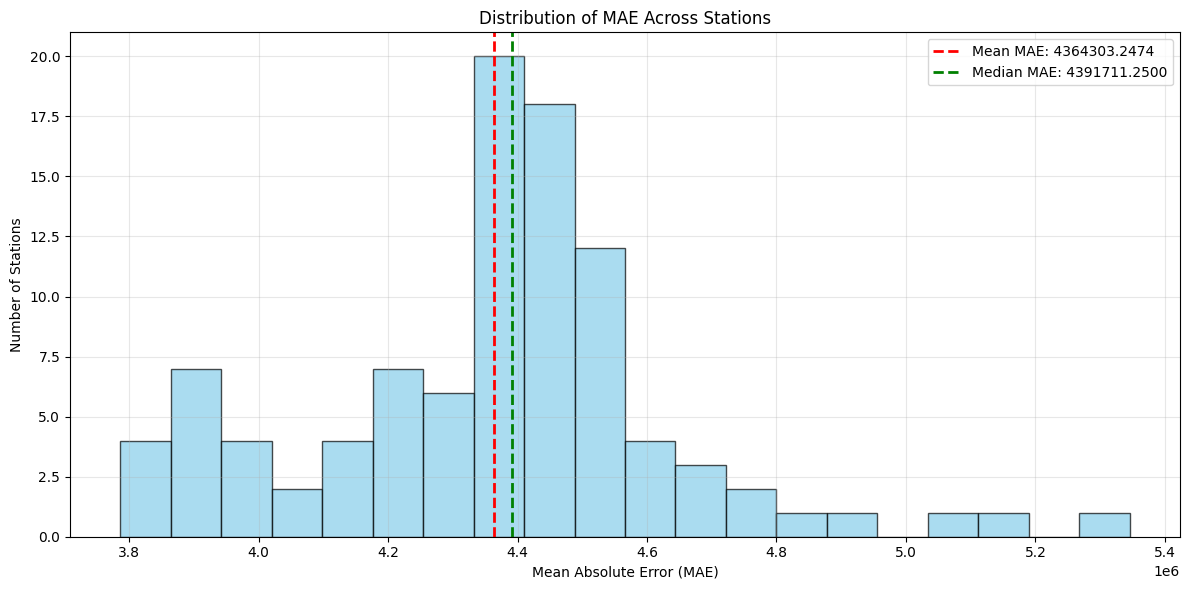

In [ ]:
# Plot histogram of stationwise MAE
plt.figure(figsize=(12, 6))
plt.hist(station_report['MAE'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(station_report['MAE'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean MAE: {station_report["MAE"].mean():.4f}')
plt.axvline(station_report['MAE'].median(), color='green', linestyle='dashed', linewidth=2, label=f'Median MAE: {station_report["MAE"].median():.4f}')
plt.title('Distribution of MAE Across Stations')
plt.xlabel('Mean Absolute Error (MAE)')
plt.ylabel('Number of Stations')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


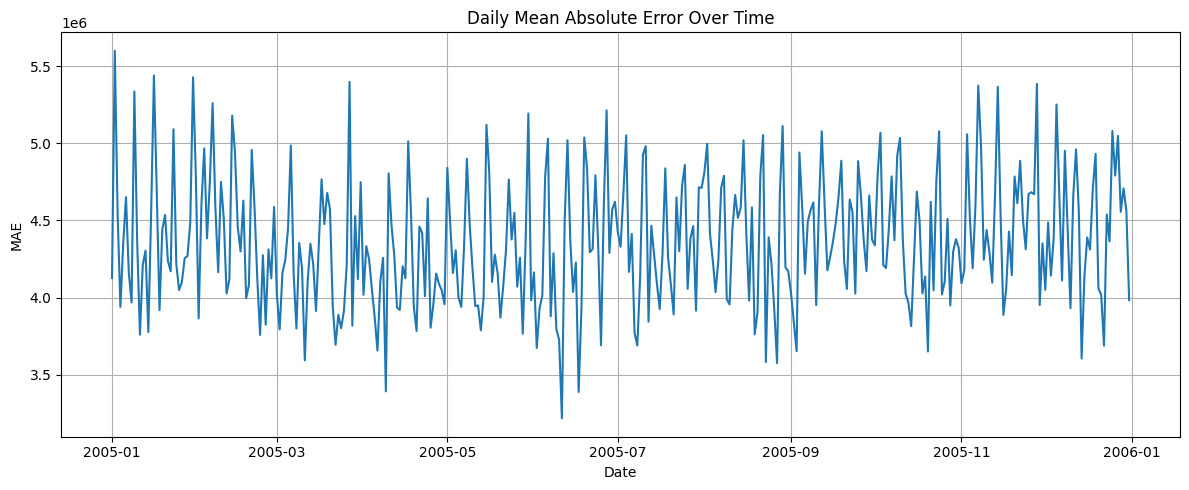

In [ ]:
# Plot Average MAE over entire test duration
plt.figure(figsize=(12, 5))
daily_errors = df_test.groupby(df_test['date'].dt.date)['error'].mean()
daily_errors.plot()
plt.title("Daily Mean Absolute Error Over Time")
plt.ylabel("MAE")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_stations(df_test, station_report, flag="best",n=5):
    """
    Plot the prediction performance for the best or worst performing stations
    """
    if flag == "best":
        stations = station_report.tail(n)['Station ID'].values
    else:
        stations = station_report.head(n)['Station ID'].values

    fig, axes = plt.subplots(n, 1, figsize=(14, 4*n))

    for i, station in enumerate(stations):
        station_data = df_test[df_test['stid'] == station].sort_values('date')

        if len(station_data) > 0:
            ax = axes[i] if n > 1 else axes
            ax.plot(station_data['date'], station_data['true'], 'b-', label='Actual')
            ax.plot(station_data['date'], station_data['pred'], 'r--', label='Predicted')
            ax.set_title(f'Station: {station} - MAE: {mean_absolute_error(station_data["true"], station_data["pred"]):.4f}')
            ax.set_ylabel('Solar Energy Production')
            ax.grid(True, alpha=0.3)
            ax.legend()

    plt.tight_layout()
    plt.show()

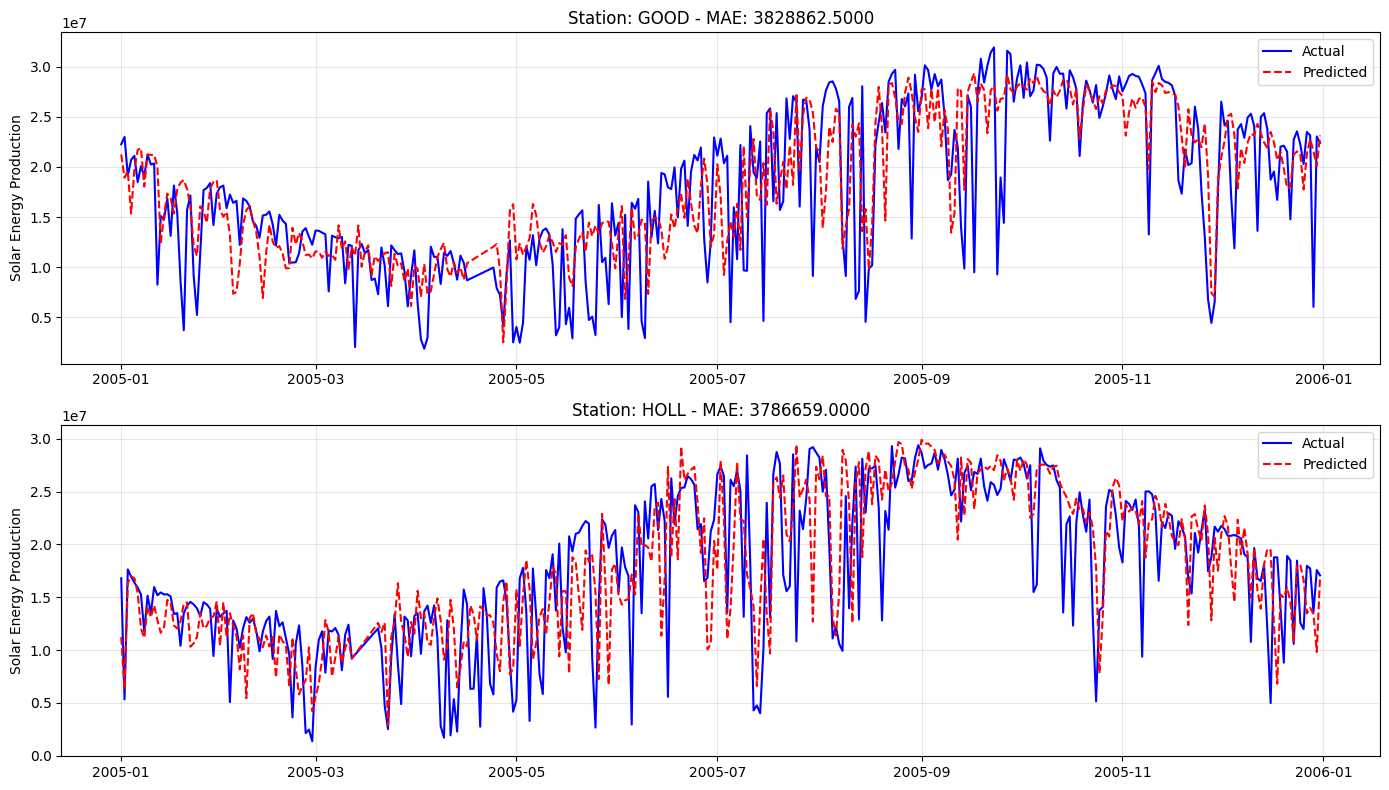

In [ ]:
# Plot best performing stations
plot_stations(df_test, station_report, "best",n=2)

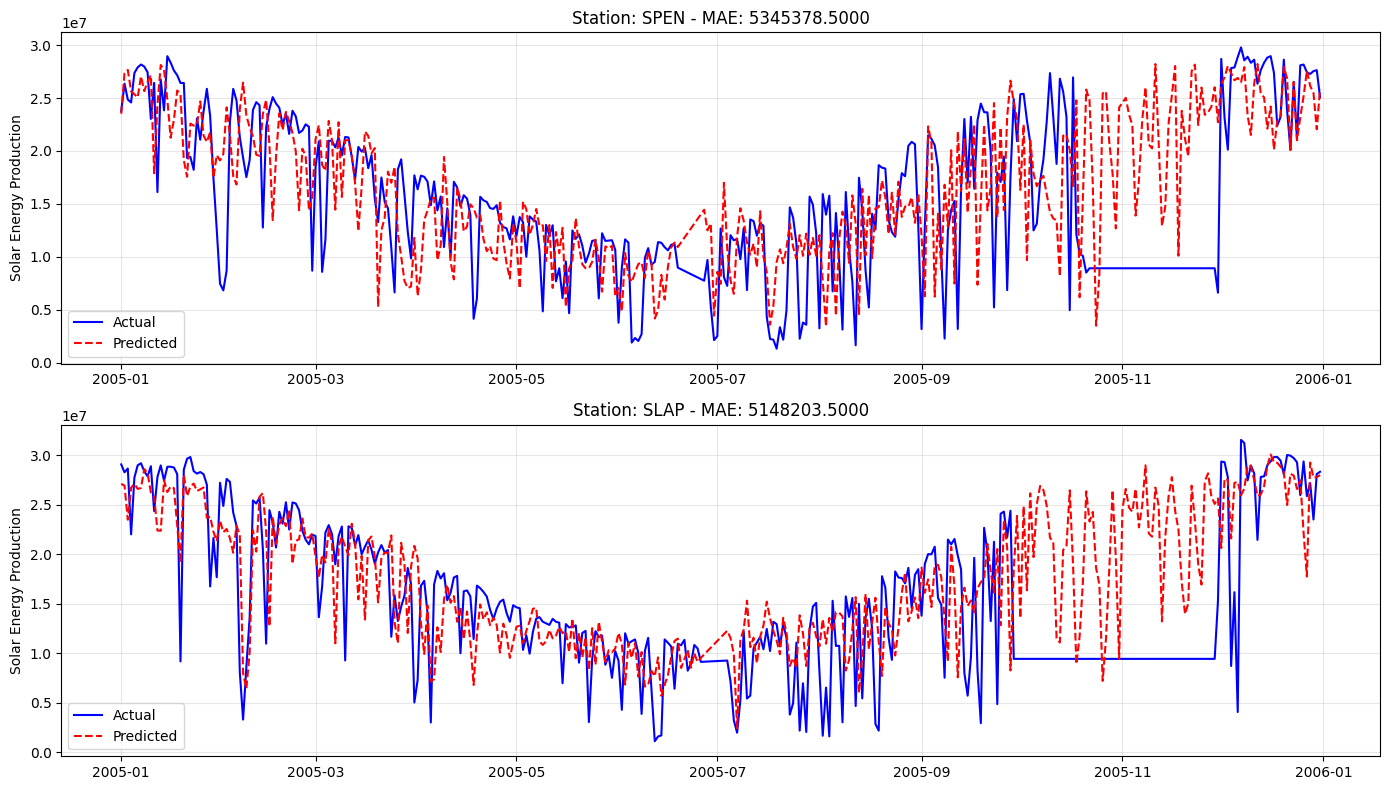

In [ ]:
# Plot worst performing stations
plot_stations(df_test, station_report, "worst",n=2)

##Explainability using Permutation Importance

In [ ]:
from sklearn.metrics import mean_absolute_error
import copy

all_feature_names = weather_features + ['dayofyear', 'month', 'weekday', 'lat', 'lon', 'stid_encoded']

def permutation_importance(model, X_val, y_val, baseline_mae, feature_names):
    importances = []
    # Iterate over the actual number of features in X_val
    for i in range(X_val.shape[2]):
        X_temp = copy.deepcopy(X_val)
        # Shuffle the feature across time and samples for the current feature index i
        np.random.shuffle(X_temp[:, :, i])
        y_pred = model.predict(X_temp)
        y_pred = scaler_y.inverse_transform(y_pred)
        score = mean_absolute_error(y_val, y_pred)
        importances.append(score - baseline_mae)
    # Return importances and the corresponding feature names
    return np.array(importances), feature_names

# Calculate baseline MAE
baseline_mae = mean_absolute_error(y_test, y_pred)

# Calculate importances using the full list of feature names
# Pass the correct list of all feature names to the function
importances, feat_names = permutation_importance(lstm_model, X_test_scaled, y_test, baseline_mae, all_feature_names)

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
1097/1097 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
1097/1097 ━

IndexError: index 24 is out of bounds for axis 0 with size 24

<Figure size 1000x800 with 0 Axes>

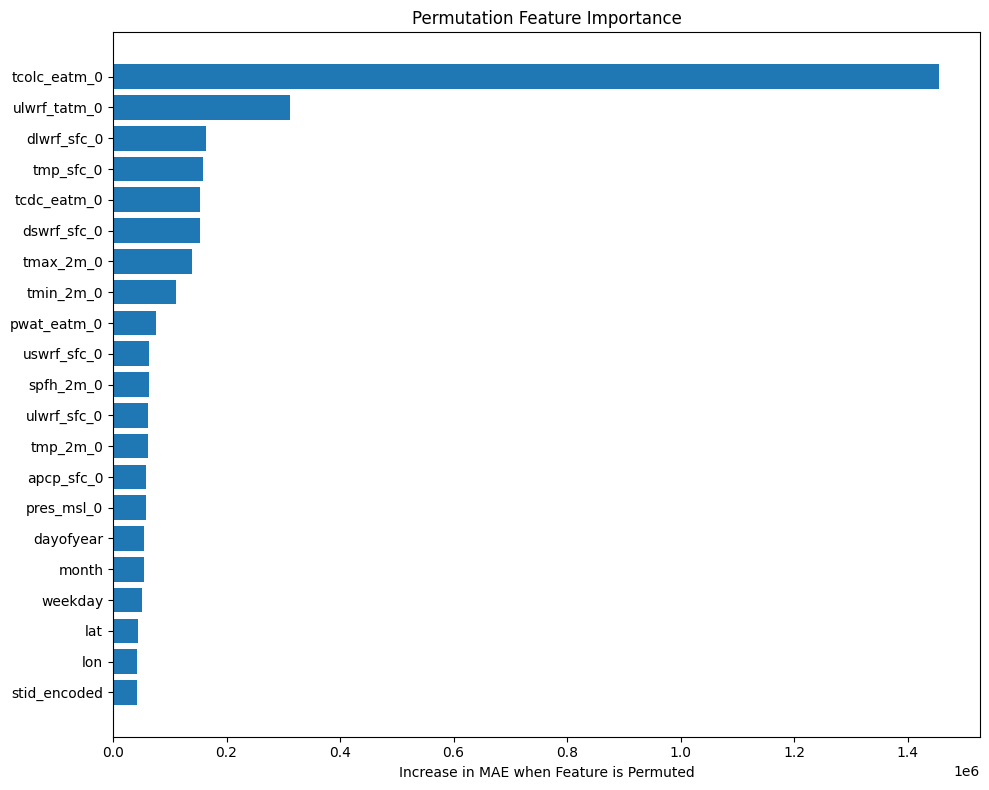

In [ ]:
# Plot
plt.figure(figsize=(10, 8)) # Increased figure height to accommodate more bars
sorted_idx = np.argsort(importances)[::-1][:24]
# Ensure we are plotting using the correct feature names array
importances = importances[sorted_idx]
feat_names = np.array(feat_names)[sorted_idx]
plt.barh(np.array(feat_names)[sorted_idx], importances[sorted_idx])
plt.xlabel("Increase in MAE when Feature is Permuted")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()